## ML Techniques I Summative chatbot (specific domain medical q&a chatbot)

In [1]:
# Download dataset using kagglehub
import kagglehub

dataset_path = kagglehub.dataset_download('thedevastator/comprehensive-medical-q-a-dataset')
print('Dataset successfully downloaded.')

Dataset successfully downloaded.


In [2]:
#  print the dataset path s content

!ls $dataset_path

train.csv


In [3]:
#  Install required libraries
%%capture
%pip install transformers huggingface_hub datasets==2.16.0

In [4]:
# Import libraries
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForQuestionAnswering, GPT2LMHeadModel,
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling
)
from huggingface_hub import login
import wandb

In [5]:
# Authenticate Hugging Face and Weights & Biases
login(token="---")
wandb.login(key="--")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-ahmat (m-ahmat-african-leadership-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
dataset = load_dataset('csv', data_files=dataset_path + '/train.csv')

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.11/dist-packages/datasets/download/streaming_download_manager.py:778: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


# preprcessing

In [7]:
pd.read_csv(dataset_path + '/train.csv')

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."
...,...,...,...
16402,symptoms,What are the symptoms of Familial visceral myo...,What are the signs and symptoms of Familial vi...
16403,information,What is (are) Pseudopelade of Brocq ?,Pseudopelade of Brocq (PBB) is a slowly progre...
16404,symptoms,What are the symptoms of Pseudopelade of Brocq ?,What are the signs and symptoms of Pseudopelad...
16405,treatment,What are the treatments for Pseudopelade of Br...,Is there treatment or a cure for pseudopelade ...


In [8]:
import pandas as pd
data = pd.read_csv(dataset_path + '/train.csv')
data = data.drop(columns=['qtype'])
print(data.head())

                                            Question  \
0  Who is at risk for Lymphocytic Choriomeningiti...   
1  What are the symptoms of Lymphocytic Choriomen...   
2  Who is at risk for Lymphocytic Choriomeningiti...   
3  How to diagnose Lymphocytic Choriomeningitis (...   
4  What are the treatments for Lymphocytic Chorio...   

                                              Answer  
0  LCMV infections can occur after exposure to fr...  
1  LCMV is most commonly recognized as causing ne...  
2  Individuals of all ages who come into contact ...  
3  During the first phase of the disease, the mos...  
4  Aseptic meningitis, encephalitis, or meningoen...  


In [9]:
# Load and preprocess the dataset

data = data.rename(columns={'Question': 'question', 'Answer': 'answer'})


In [10]:
data.head()

,question,answer
0,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


In [16]:
# Split dataset into train, validation, and test
train_full, test_set = train_test_split(data, test_size=0.2, random_state=56)
train_set, val_set = train_test_split(train_full, test_size=0.25, random_state=56)

# Limit validation set to first 500 samples
val_set = val_set.iloc[:500]

In [17]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_set)
val_dataset = Dataset.from_pandas(val_set)
test_dataset = Dataset.from_pandas(test_set)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})


# visualizations

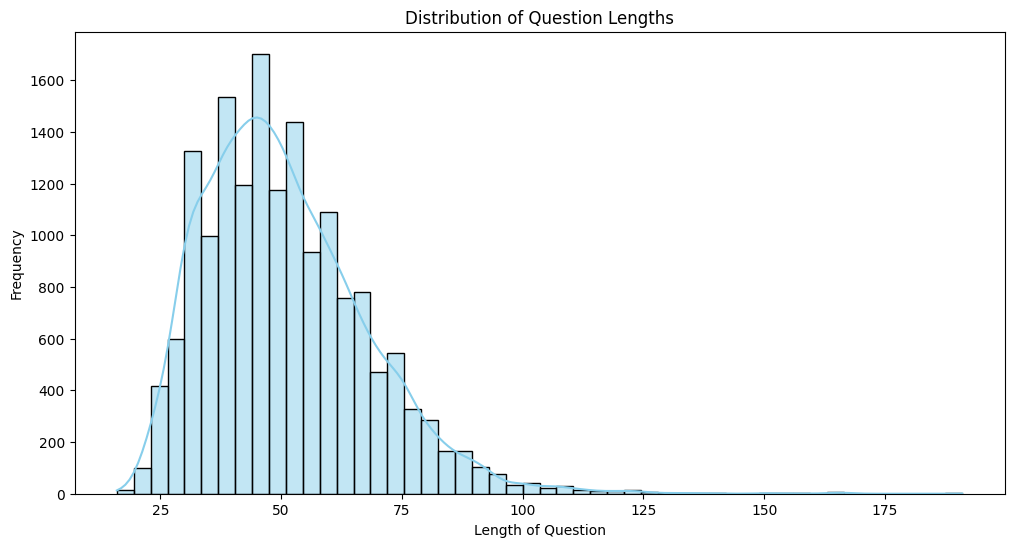

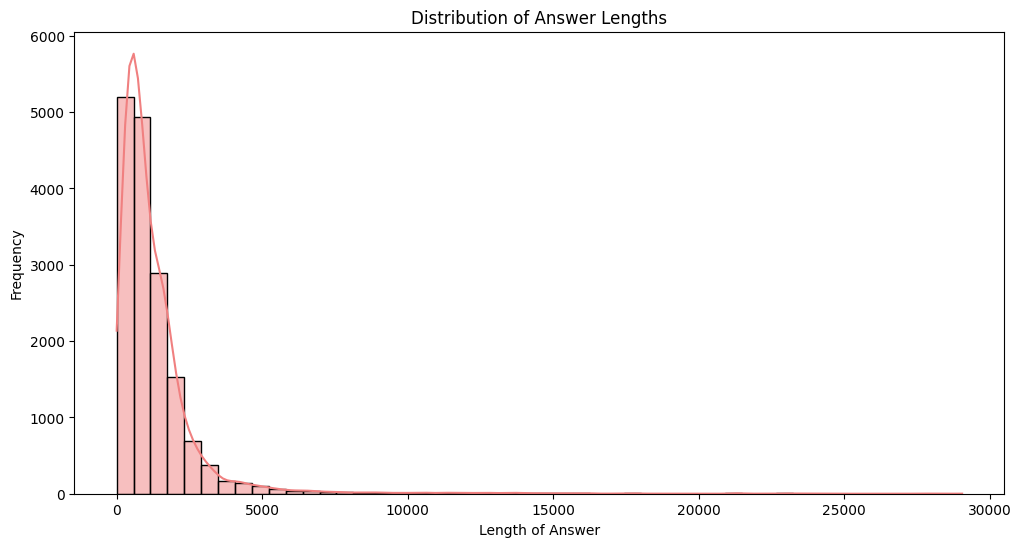


Basic Statistics:
       question_length  answer_length
count     16407.000000   16407.000000
mean         50.684952    1303.452673
std          16.926465    1656.694326
min          16.000000       6.000000
25%          38.000000     487.000000
50%          48.000000     890.000000
75%          61.000000    1589.000000
max         191.000000   29046.000000


In [18]:
# Some visualizations of the dataset

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of question and answer lengths
data['question_length'] = data['question'].apply(len)
data['answer_length'] = data['answer'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data['question_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Length of Question')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['answer_length'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length of Answer')
plt.ylabel('Frequency')
plt.show()

# Display basic statistics about the data
print("\nBasic Statistics:")
print(data[['question_length', 'answer_length']].describe())

# Load pre-trained T5 model and tokenizer (for QA)

In [19]:
# Load pre-trained T5 model and tokenizer (for QA)
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
model  # Output model summary

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

# Format for T5 and tokenize


In [20]:
# Format for T5 and tokenize
def format_qa_t5(example):
    inputs = ["question: " + q for q in example["question"]]
    model_inputs = tokenizer(inputs, max_length=128, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["answer"], max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize datasets
tokenized_data = dataset_dict.map(format_qa_t5, batched=True, remove_columns=dataset_dict["train"].column_names)


Map:   0%|          | 0/9843 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3282 [00:00<?, ? examples/s]

# Finetuning

In [24]:
#  Define improved training parameters
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_steps=10,
    report_to=None,
    push_to_hub=False
)

#  Train with early stopping and Seq2Seq collator

In [25]:
#  Train with early stopping and Seq2Seq collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

/tmp/ipython-input-25-280762838.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.329900,1.945614
2,1.852200,1.849763
3,1.837400,1.796978
4,1.566800,1.771350
5,1.619200,1.761654


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=6155, training_loss=1.9142923570473342, metrics={'train_runtime': 1067.6791, 'train_samples_per_second': 46.095, 'train_steps_per_second': 5.765, 'total_flos': 1665211689861120.0, 'train_loss': 1.9142923570473342, 'epoch': 5.0})

#  Visualize training metrics

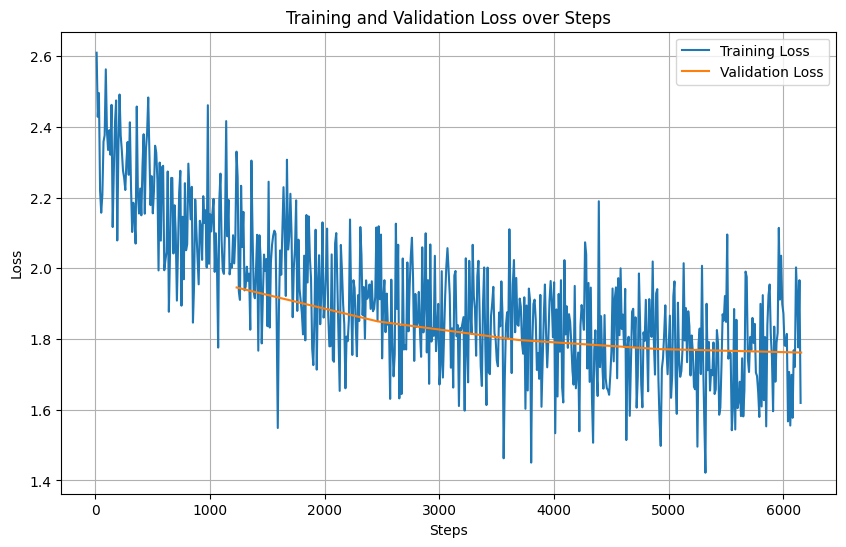

In [26]:

#  Visualize training metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Get training history from the trainer
train_history = trainer.state.log_history

# Extract loss values
train_loss = [entry['loss'] for entry in train_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in train_history if 'eval_loss' in entry]
train_steps = [entry['step'] for entry in train_history if 'loss' in entry]
eval_steps = [entry['step'] for entry in train_history if 'eval_loss' in entry]


# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
sns.lineplot(x=train_steps, y=train_loss, label='Training Loss')
sns.lineplot(x=eval_steps, y=eval_loss, label='Validation Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()



In [27]:
# Save the model
model.save_pretrained("/kaggle/working/trained-model")
tokenizer.save_pretrained("/kaggle/working/trained-model")

('/kaggle/working/trained-model/tokenizer_config.json',
 '/kaggle/working/trained-model/special_tokens_map.json',
 '/kaggle/working/trained-model/spiece.model',
 '/kaggle/working/trained-model/added_tokens.json')

# Evaluation

In [28]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [29]:
import evaluate

In [31]:
# Step 12: Generate predictions using best checkpoint
from tqdm import tqdm

def generate_answer(prompt, model, tokenizer, max_length=64):
    input_text = "question: " + prompt
    input_ids = tokenizer.encode(input_text, return_tensors="pt")
    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [32]:
# Load trained model for evaluation
model = T5ForConditionalGeneration.from_pretrained("/kaggle/working/trained-model")
tokenizer = T5Tokenizer.from_pretrained("/kaggle/working/trained-model")

In [33]:
predictions = []
references = []

for i in tqdm(range(50)):
    question = test_dataset['question'][i]
    reference = test_dataset['answer'][i]

    pred = generate_answer(question, model, tokenizer)
    if pred and isinstance(reference, str):
        predictions.append(pred.strip())
        references.append([reference.strip()])

print(f"# Predictions: {len(predictions)}")
print(f"# References: {len(references)}")

100%|██████████| 50/50 [02:17<00:00,  2.76s/it]

# Predictions: 50
# References: 50


In [34]:
# Evaluate with BLEU
import evaluate
bleu = evaluate.load("bleu")
bleu_result = bleu.compute(predictions=predictions, references=references)
print("📊 BLEU Score:", bleu_result['bleu'])


📊 BLEU Score: 0.01417268015643343


In [36]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6a0a30e9e41466489e94615bd0ba0dee1a2265eeeacbbf2a516f32d362524b83
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [37]:
# Evaluate with ROUGE
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
print("📊 ROUGE Score:")
for k, v in rouge_result.items():
    print(f"  {k}: {v}")

📊 ROUGE Score:
  rouge1: 0.2954444299839109
  rouge2: 0.17994513747772967
  rougeL: 0.24441907733375723
  rougeLsum: 0.25001687097112446
